# Generate INNER calibration

John Curtin & Claire Punturieri  
October 15, 2024

In [ ]:
study <- params$study
cv <- params$cv
model <- params$model
algorithms <- params$algorithms
version <- params$version
window <- params$window


Function conflicts

In [ ]:

# source
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

Path

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))


## Functions

In [ ]:
get_brier <- function(split, df){
  
  #filter to split
  probs_split <- df |> 
    filter(split_num == split)

  raw <- probs_split |>
    filter(method == "prob_raw") |> 
    brier_class(label, .pred_Lapse)
  
  logi <- probs_split |>
    filter(method == "prob_logi") |> 
    brier_class(label, .pred_Lapse)
  
  iso <- probs_split |>
    filter(method == "prob_iso") |> 
    brier_class(label, .pred_Lapse)
  
  #beta <- probs_split |>
    #filter(method == "prob_beta") |> 
    #brier_class(label, .pred_Lapse)
  
  brier <- tibble(raw = raw$.estimate, 
                 logi = logi$.estimate, 
                 iso = iso$.estimate) 
  #               beta = beta$.estimate)
  
  #brier <- tibble(raw = raw$.estimate)
  
  return(brier)
}


## Get Probs

In [ ]:
probs <- read_rds(here::here(path_models,
                             str_c("inner_preds_", window, "_", version, "_",
                                         cv, "_", model, ".rds"))) |>
  mutate(split_num = 10 * outer_split_num + (inner_split_num - 10)) |> 
  pivot_longer(cols = starts_with("prob"), 
               names_to = "method", 
               values_to = ".pred_Lapse") |>
  glimpse()


Rows: 932,391
Columns: 7
$ id_obs          <int> 446, 446, 446, 447, 447, 447, 448, 448, 448, 449, 449,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…
$ split_num       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ method          <chr> "prob_raw", "prob_iso", "prob_logi", "prob_raw", "prob…
$ .pred_Lapse     <dbl> 0.32092649, 0.00000000, 0.08943453, 0.32092649, 0.0000…

## Brier Scores

In [ ]:
brier <- 1:300 |>
  map(\(split_num) get_brier(split_num, probs)) |> 
  list_rbind()

brier |> head()


# A tibble: 6 × 3
    raw   logi    iso
  <dbl>  <dbl>  <dbl>
1 0.182 0.0536 0.0503
2 0.164 0.0175 0.0139
3 0.238 0.0787 0.0758
4 0.182 0.0727 0.0730
5 0.203 0.0540 0.0436
6 0.239 0.0978 0.0995

# A tibble: 1 × 6
  raw_1 raw_2 logi_1 logi_2  iso_1  iso_2
  <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1 0.195 0.194 0.0684 0.0666 0.0680 0.0664

## Explore Plots

Raw and logi

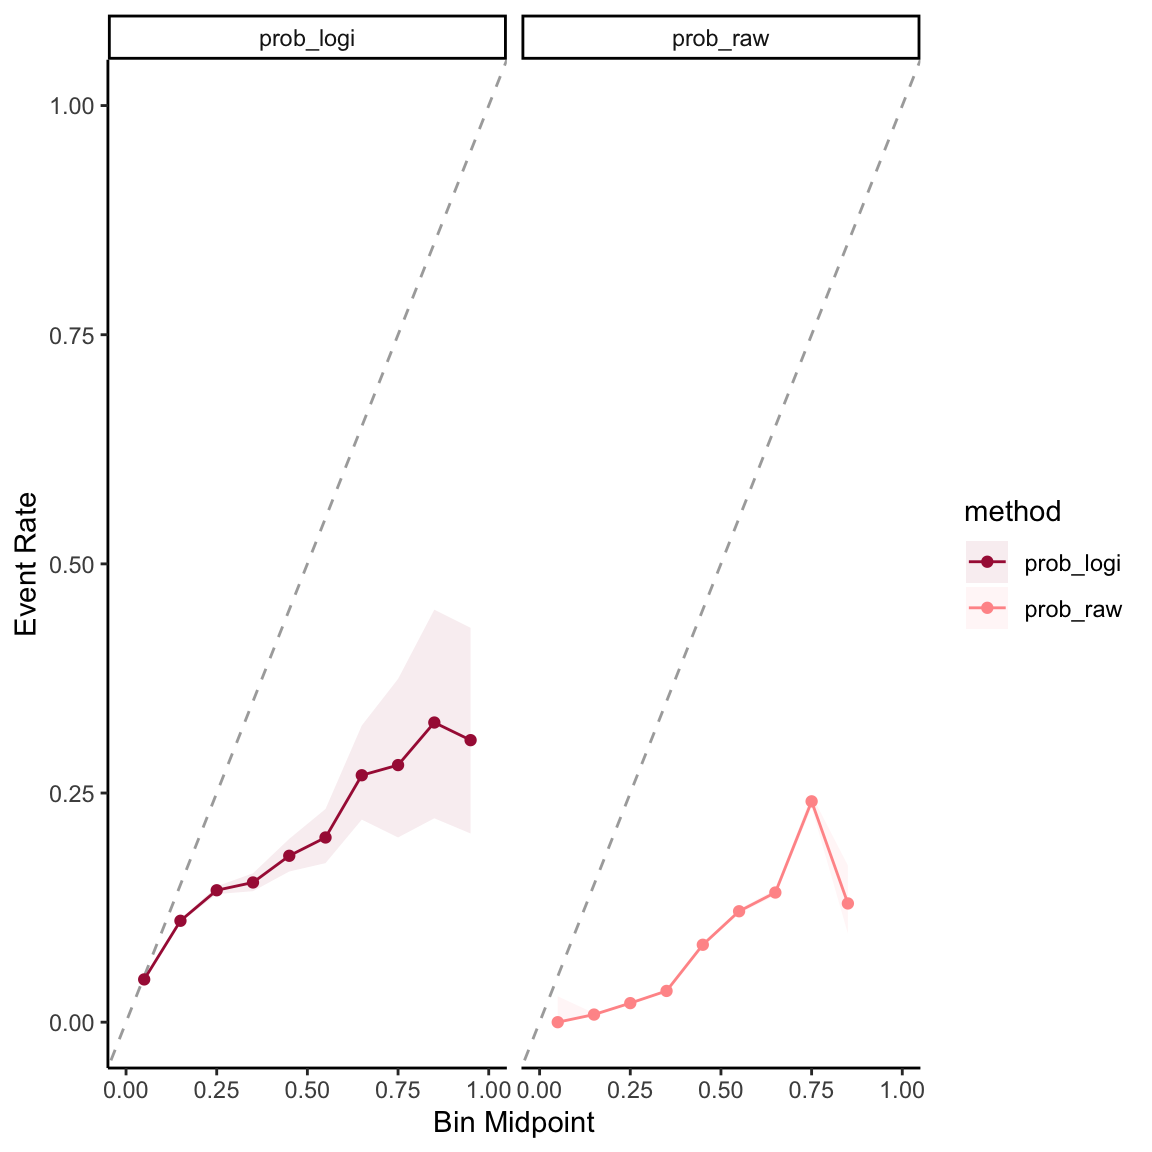

In [ ]:
cols <- c("prob_raw" = "#FF9898FF", "prob_logi" = "#A91E45FF")

probs |>
  mutate(.pred_lapse = .pred_Lapse) |>
  filter(method == "prob_raw" | method == "prob_logi") |> 
  #filter(outer_split_num == 1) |>
  cal_plot_breaks(truth = label, 
                  estimate = .pred_lapse,
                  .by = method) +
  scale_color_manual(values = cols,
                     aesthetics = c("color", "fill")) +
  theme_classic()
